Desde la terminal:

```bash
pip install -r requirements.txt
````

In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

2024-10-05 18:25:08.279423: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-05 18:25:08.296804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 18:25:08.316992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 18:25:08.323020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 18:25:08.337607: I tensorflow/core/platform/cpu_feature_guar

## DATASET

CelebA dataset, redimensionado a 64x64

NO ejecutar esta celda si ya tienes el dataset descargado

In [6]:
os.makedirs("celeba_gan") 

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

# Eliminar el zip descargado
os.remove("celeba_gan/data.zip")

In [13]:
# TO-DO: Eliminar el 95% de las imágenes

In [ ]:
# Crea un conjunto de datos a partir de la ruta donde están las imágenes
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan", 
    label_mode=None, 
    image_size=(64, 64), 
    batch_size=32
)

# Reescala las imágenes al rango [0, 1]
dataset = dataset.map(lambda x: x / 255.0)

Ejemplo de imagen

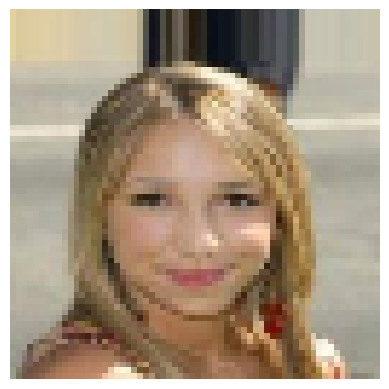

In [7]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## MODELO

Red discriminadora

In [16]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        keras.layers.LeakyReLU(negative_slope=0.2),
        keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        keras.layers.LeakyReLU(negative_slope=0.2),
        keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        keras.layers.LeakyReLU(negative_slope=0.2),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="sigmoid"), # 1 neurona para clasificar entre real o falso
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Red generadora

In [17]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        keras.layers.Dense(8 * 8 * 128),
        keras.layers.Reshape((8, 8, 128)),
        keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        keras.layers.LeakyReLU(negative_slope=0.2),
        keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        keras.layers.LeakyReLU(negative_slope=0.2),
        keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        keras.layers.LeakyReLU(negative_slope=0.2),
        keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

Bucle de entrenamiento

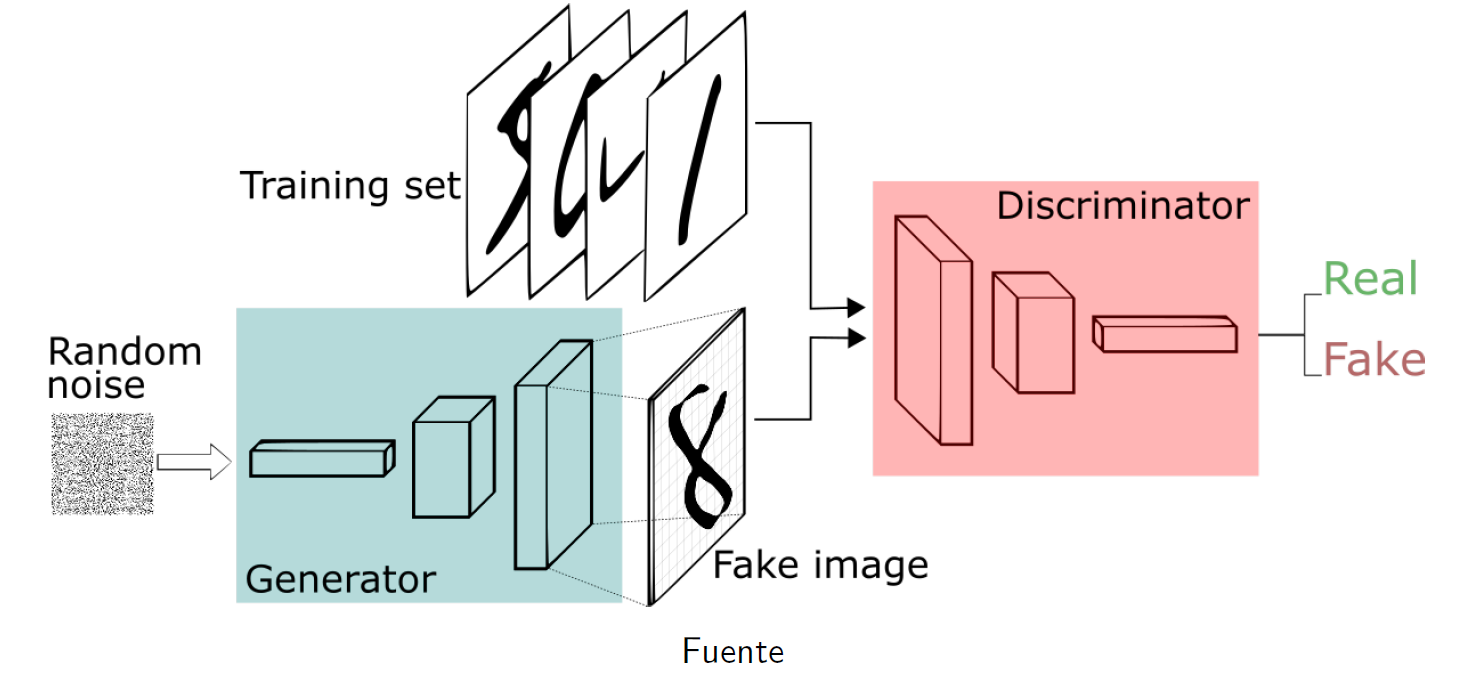

In [18]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Muestreo de puntos aleatorios en el espacio latente (ruido)
        batch_size = keras.ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # La genedora genera las imágenes a partir del ruido/espacio latente
        generated_images = self.generator(random_latent_vectors)

        # Las combinamos con imágenes reales del dataset
        combined_images = keras.ops.concatenate([generated_images, real_images], axis=0)

        # Asignar las etiquetas correspondientes a cada imagen de "combined_images"
        labels = keras.ops.concatenate(
            [keras.ops.ones((batch_size, 1)), keras.ops.zeros((batch_size, 1))], axis=0
        )
        # Esto es un truco de entrenamiento, añadiendo ruido a las etiquetas se impide que el discriminador overfitee generalizando así mejor.
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # --- Entrenar discriminadora ---
        # Aquí no se actualizan los pesos de la generadora!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        # ---

        # --- Entrenar generadora ---
        # En este caso se pasan a la discriminadora SOLO imágenes de la generadora
        # Aquí no se actualizan los pesos de la discriminadora!
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        ) #  Muestreo de z (puntos aleatorios en el espacio latente)

        # Para las predicciones de las etiquetas de las imágenes producidas por generadora -> todas deberían ser 0
        misleading_labels = keras.ops.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        # ---

        # Update de las métricas
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## ENTRENAMIENTO

In [47]:
epochs = 1

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# el batch_size ya va especificado en la variable dataset
gan.fit(
    dataset, 
    epochs=epochs,
    # TO-DO: Añadir un callback para guardar imágenes generadas por la generadora en cada epoch
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step/step - d_loss: 0.6515 - g_loss: 1.184
573/573 ━━━━━━━━━━━━━━━━━━━━ 146s 244ms/step - d_loss: 0.6515 - g_loss: 1.1841


## TAREAS
- Eliminar el 95% de las imágenes del dataset
- Añadir un callback para guardar imágenes generadas por la generadora en cada epoch